This notebook compares $C_\ell$s from CLASS's python wrapper and CCL, the original was by written by Danielle but has been extened to run CLASS within it and show COSMOSIS output as well

In [1]:
import numpy as np
import pyccl as ccl
import scipy.integrate
from scipy.special import factorial
from scipy.interpolate import interp1d
from classy import Class
import matplotlib.pyplot as plt
import os

# First we compare CCL and CLASS for very simple Gaussian dNdz

In [2]:
# Cosmological parameters
OmC = 0.3; OmB = 0.04; h= 0.72; A_s = 2.1*10**(-9); n_s = 0.96; Neff = 3.046; w0=-0.9; wa=0.

# CCL

We're going to use a simple Gaussian dNdz for this comparison. We'll use a normalized Gaussian centered at z=0.5 and stddev = 0.1:
$ \frac{dN}{dz} = \frac{1}{\sqrt{2\pi}(0.1)} \exp \left(-\frac{(z - 0.5)^2}{2 (0.1)^2}\right)$

In [3]:
z = np.linspace(0., 3., 5000) # I am making a really highly sampled z vector.
dNdz = np.exp(-(z - 0.5)**2 / (2. * 0.1**2)) / (np.sqrt(2. * np.pi) * 0.1)

# Let's output this so that the same can be used for cosmosis:
save_dNdz = np.column_stack((z, dNdz))
# np.savetxt('./Gaussian_dNdz.txt', save_dNdz)

Let's also set up a vector of ells which we will use, ranging from 2 to $10^3$ = 1000. 

In [4]:
ccl_ells = np.arange(2,1001)

# Let's output this as well in case it is helpful
# np.savetxt('./ells.txt', ells)

First thing we do to do a calculation in CCL is set up a cosmology object, this holds things like cosmological parameters.

In [5]:
ccl_cosmo = ccl.Cosmology(Omega_c = OmC, Omega_b = OmB, h = h, A_s = A_s, n_s = n_s, 
                         Neff = Neff, w0=w0, wa=wa)

For CCL, to get weak lensing $C_\ell$s, we first set a lensing 'tracer'. 

In [6]:
# We need (z, dNdz) as a tuple for CCL:
z_dNdz = (z, dNdz)

# We mostly will use the defaults here. By using the defaults, we are assuming 
# that there are no intrinsic alignments affecting this tracer (not physically realistic
# but the simplest case for debugging.)
ccl_tracer_lensing = ccl.WeakLensingTracer(ccl_cosmo, dndz=z_dNdz)

Now we stick two of these tracers together to get the $C_\ell$s

In [7]:
ccl_Cl_lensing = ccl.angular_cl(ccl_cosmo, ccl_tracer_lensing, ccl_tracer_lensing, ccl_ells) 

# CLASS


In [8]:
# sCl means "I need the galaxy lensing potential to be output, please."
# selection, selection mean, and selection width should allow CLASS to set up a Gaussian.
class_params = {'output': 'sCl', 'non linear': 'halofit', 'z_max_pk': 500.0, 'modes': 's', 
                'lensing':'no', 'h': h, 'Omega_cdm': OmC, 'Omega_b': OmB, 'Omega_k': 0.0, 'n_s': n_s, 'Omega_Lambda': 0.0, 
                'w0_fld': -0.9, 'wa_fld': 0.0, 'N_ur': 3.046, 'T_cmb': 2.725, 'A_s': A_s, 'l_max_lss': 1000,
                'selection': 'gaussian', 'selection_mean': 0.5, 'selection_width': 0.1,
                'k_max_tau0_over_l_max': 15,}
#                 'l_switch_limber_for_nc_local_over_z': 10000,
#                 'l_switch_limber_for_nc_los_over_z': 2000}

# Set up the object that does everything.
class_cosmo = Class();
class_cosmo.set(class_params);

In [9]:
# Compute the things we asked for
class_cosmo.compute()

In [10]:
# initialize ell values and prefactors that we want to test
class_ell = np.arange(2, 1001)
class_factor = 1/4. * (class_ell+2)*(class_ell+1)*class_ell*(class_ell-1) #(ell+2)!/(ell-2)!
class_density_cl = class_cosmo.density_cl(1000) # this is a dict

Let's plot the $C_\ell$s

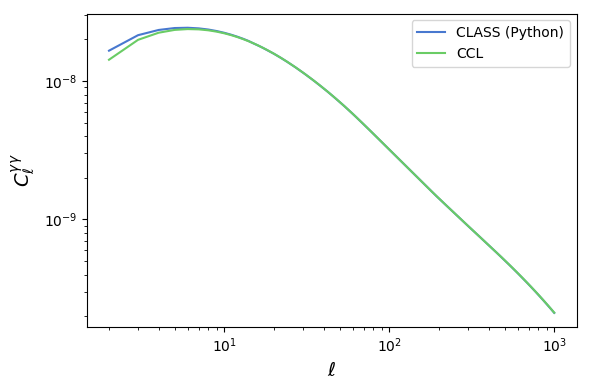

In [11]:
with plt.style.context('seaborn-muted'):
    plt.figure(dpi = 100)

    plt.loglog(class_density_cl['ell'][2:],  class_factor * class_density_cl['ll'][0][2:] , '-', label='CLASS (Python)')
    plt.loglog(ccl_ells, ccl_Cl_lensing, label="CCL")
    
    plt.xlabel(r"$\ell$", fontsize=14)
    plt.ylabel(r"$C_\ell^{\gamma \gamma}$", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

And the relative difference $\frac{C_\ell^{CLASS}}{C_\ell^{CCL}}$

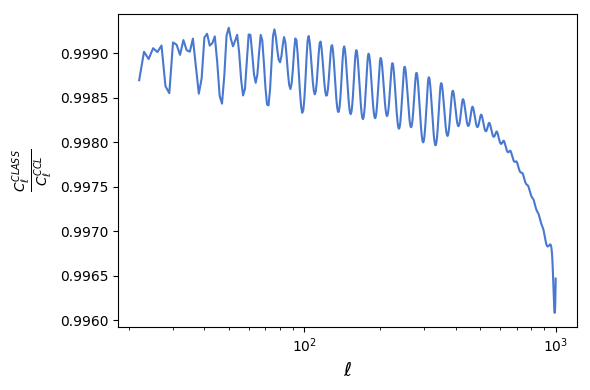

In [12]:
with plt.style.context('seaborn-muted'):
    plt.figure(dpi = 100)
    plt.semilogx(ccl_ells[20:], (class_factor[20:] * class_density_cl['ll'][0][2:][20:])/(ccl_Cl_lensing[20:]))
    
    plt.xlabel(r"$\ell$", fontsize=14)
    plt.ylabel(r"$\frac{C_\ell^{CLASS}}{C_\ell^{CCL}}$", fontsize=14)
    plt.tight_layout()
    plt.show()

The difference at low $\ell$s probably has to do with the Limber approximation, but for the $\ell$s we care about it is not significant

# Now we try with a Smail type dndz

# We test CLASS, CCL, and COSMOSIS

## CLASS

We use a Smail type pdf for the dNdz, CLASS requires a file with two columns: first being the z values and the second being
the dNdz. This class is lifted from the `photoZ_model.py` file

In [13]:
class SmailZ(object):
    def __init__(self, z_support, z0, gamma, alpha):
        self.z0 = z0
        self.gamma = gamma
        self.alpha = alpha
        pdf = z_support ** alpha * np.exp(-(z_support / z0) ** (gamma))
        self.z_support = z_support
        self.pdf = pdf / np.trapz(pdf, z_support)

    def get_pdf(self):
        return self.pdf
    
    def get_z_support(self):
        return self.z_support
    
    def f(self, x):
        return x ** self.alpha * np.exp(-(x/self.z0) ** (self.gamma))

    def normed_f(self, x):
        return self.f(x)/quad(self.f, self.z_support[0], self.z_support[-1])[0]

def get_smail(z0, gamma, alpha):
    # initialize pdf
    z_support = np.linspace(0.0, 5.0, num=500)
    pdf_z = SmailZ(z_support, z0=z0, gamma=gamma, alpha=alpha)
    return pdf_z

We use the following parameters for lensing for the smail type pdf

In [14]:
z0 = 0.51
gamma = 1.01
alpha = 1.24

pdf_z = get_smail(z0, gamma, alpha)
z, dNdz = pdf_z.get_z_support(), pdf_z.get_pdf()


Put the `z` and `dNdz` in the required two column format

In [114]:
z_dNdz_class = np.vstack((z.T, dNdz.T)).T 
np.savetxt("tomo_source_class3.dat", z_dNdz_class)

Plot of `dNdz` vs `z`, the black lines denote the  tophat bins we will use, and the blue dashed lines denote the location of the center of the bins.

CLASS for some reason wants the z-support to be larger than the right endpointof the rightmost bin - it crashes otherwise, hence the reason the z values go to 5

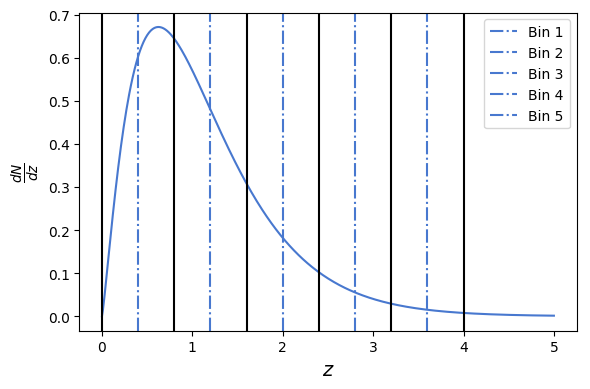

In [15]:
with plt.style.context('seaborn-muted'):
    plt.figure(dpi = 100)
    plt.plot(z, dNdz)
    for i in range(6):
        plt.axvline(x=0.4*(2*i), color='k', linestyle='-')
        if i < 5:
            plt.axvline(x=0.4*(2*i+1), linestyle='-.', label="Bin %d"%(i+1))
#         print 0.4 * (2*i + 1),
    plt.xlabel(r'$z$', fontsize=14)
    plt.ylabel(r'$\frac{dN}{dz}$', fontsize=14)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [16]:
ells = np.arange(2, 1001)

First we set up a cosmology object, note that we use a tophat selection function, supply the mean z's for each bin and the width,
the non-diagonal term just means that we ant all cross-correlations.

Note the parameter `k_max_tau0_over_l_max` is a precision parameter, don't include it for a fast run expect more disagreement with CCL and COSMOSIS at high ells. Set it around 10-15 for a better match. The larger it is, the longer CLASS takes to run

An ini file is also provided in the `class` folder

In [17]:
class_params = {'output': 'sCl', 'non linear': 'halofit', 'z_max_pk': 500.0, 'modes': 's', 
                'lensing':'no', 'h': h, 'Omega_cdm': OmC, 'Omega_b': OmB, 'Omega_k': 0.0, 'n_s': n_s, 'Omega_Lambda': 0.0, 
                'w0_fld': -0.9, 'wa_fld': 0.0, 'N_ur': 3.046, 'T_cmb': 2.725, 'A_s': A_s, 'l_max_lss': 1000,
                'selection': 'tophat', 'selection_mean': '0.4,1.2,2.0,2.8,3.6', 'selection_width': 0.4, 'non_diagonal':4,
                'dNdz_selection': 'tomo_source_class3.dat',
                'k_max_tau0_over_l_max': 15, }

# Set up the object that does everything.
class_cosmo = Class();
class_cosmo.set(class_params);

This checks if we have already run the program and only computes new $C_\ell$s if the files containg the $C_\ell$s don't exist. At high precisions, this can take a while to run...

When running CLASS in python the shear $C_\ell$'s we want are stored in the `density_cl` dictionary. Unlike CLASS from the shell, the $C_\ell$s are not dimensionless here


In [56]:
class_cl_path = "class/class_high_precision/class_cls.dat"
if os.path.exists(class_cl_path):
    print "C_ells exist"
    class_cls = np.loadtxt(class_cl_path)
else:
    print "C_ells dont exist"
    class_cosmo.compute()
    class_density_cl = class_cosmo.density_cl(1000) # this is a dict
    class_cl = class_density_cl['ll']
    class_ell = class_density_cl['ell']
    class_cls = tuple([class_ell] + [class_cl[i] for i in range(15)])
    class_cls = np.vstack(class_cls).T
    np.savetxt(class_cl_path, class_cls)

C_ells exist


We pull out the $\ell$ values from this dict and set up the conversion factor from the lensing potential to the lensing spectrum we want:
$$
\frac14 \frac{(\ell + 2)!}{(\ell - 2)!}
$$

In [57]:
class_ell = class_cls[:, 0]
class_factor = 1/4. * (class_ell+2)*(class_ell+1)*class_ell*(class_ell-1) #(ell+2)!/(ell-2)!

Set up an array with the orderings of the auto and cross correleations of the $C_\ell$s

In [21]:
class_ord = """\
1       1\n2       1\n3       1\n4       1\n5       1\n2       2\n3       2\n4       2\n5       2\n3       3\n4       3\n5       3\n4       4\n5       4\n5       5"""
class_ord = [(int(i.split()[0]), int(i.split()[1])) for i in class_ord.split("\n")]
print class_ord

[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (2, 2), (3, 2), (4, 2), (5, 2), (3, 3), (4, 3), (5, 3), (4, 4), (5, 4), (5, 5)]


### We also ran a manual run with lower precision
An ini file for this has been provided in the class_low_precision folder.

We just need to load the $C_\ell$s

In [2]:
class_ell_cls_low = np.loadtxt("class/class_low_precision/comp_test_smail05_cl.dat")

This is a dimensionless lensing potential, so we need to do two conversions:

one for adding dimensions back in: multiply by $$\frac{2\pi}{\ell(\ell+1)}$$

the other for converting to the lensing spectrum: multiply by $$
\frac14 \frac{(\ell + 2)!}{(\ell - 2)!}
$$

In [24]:
class_ells_man = class_ell_cls_low[:, 0] # load ells 

# first conversion
divident = (class_ells_man*(class_ells_man + 1.0))/(2.0 * np.pi)
class_ell_cls_low[:, 1:] = np.divide(class_ell_cls_low[:, 1:].T, divident).T

# second conversion
multiplier = 1/4. * ( (class_ells_man+2)*(class_ells_man+1)*class_ells_man*(class_ells_man-1)) #(ell+2)!/(ell-2)!
class_ell_cls_low[:, 1:] = np.multiply(class_ell_cls_low[:, 1:].T, multiplier).T

# CCL

First thing we do to do a calculation in CCL is set up a cosmology object, this holds things like cosmological parameters.

In [25]:
ccl_cosmo = ccl.Cosmology(Omega_c = OmC, Omega_b = OmB, h = h, A_s = A_s, n_s = n_s, 
                         Neff = Neff, w0=w0, wa=wa)

Load the dNdz file (its already binned into seperate columns)

In [26]:
z_dNdz = np.loadtxt("tomo_source.dat")
z = z_dNdz[:, 0]
dNdz = z_dNdz[:, 1:]

Make lensing tracers for each bin

In [122]:
ccl_tracers = []
for i in range(dNdz.shape[-1]):
    # We need (z, dNdz) as a tuple for CCL:
    z_dNdz = (z, dNdz[:, i])
    
    # We mostly will use the defaults here. By using the defaults, we are assuming 
    # that there are no intrinsic alignments affecting this tracer (not physically realistic
    # but the simplest case for debugging.)
    ccl_tracers.append(ccl.WeakLensingTracer(ccl_cosmo, dndz=z_dNdz))

Stick each pair of tracers together to get auto and cross correlations; 

the orderings are the same as CLASS

In [123]:
ccl_cls = []
for ordering in class_ord:
    index1 = ordering[0] - 1
    index2 = ordering[1] - 1
    ccl_cls.append(ccl.angular_cl(ccl_cosmo, ccl_tracers[index1], ccl_tracers[index2], ells))

# COSMOSIS

Load the Cosmosis Cls for good measure. This assumes a a run of COSMOSIS has already been made.
If it hasn't, comment out the 

In [188]:
cosmosis_ells = np.loadtxt("cosmosis/parameters/shear_cl/ell.txt")
cosmosis_cls = np.zeros((len(cosmosis_ells), 15))
count = 0
for i in class_ord:
    cosmosis_cls[:, count] = np.loadtxt("cosmosis/parameters/shear_cl/bin_%d_%d.txt"%(i[0],i[1]))
    count += 1

## Plot the $C_\ell$s for CLASS and CCL and COSMOSIS

First we plot the $C_\ell$s directly for CLASS, CCL, and COSMOSIS

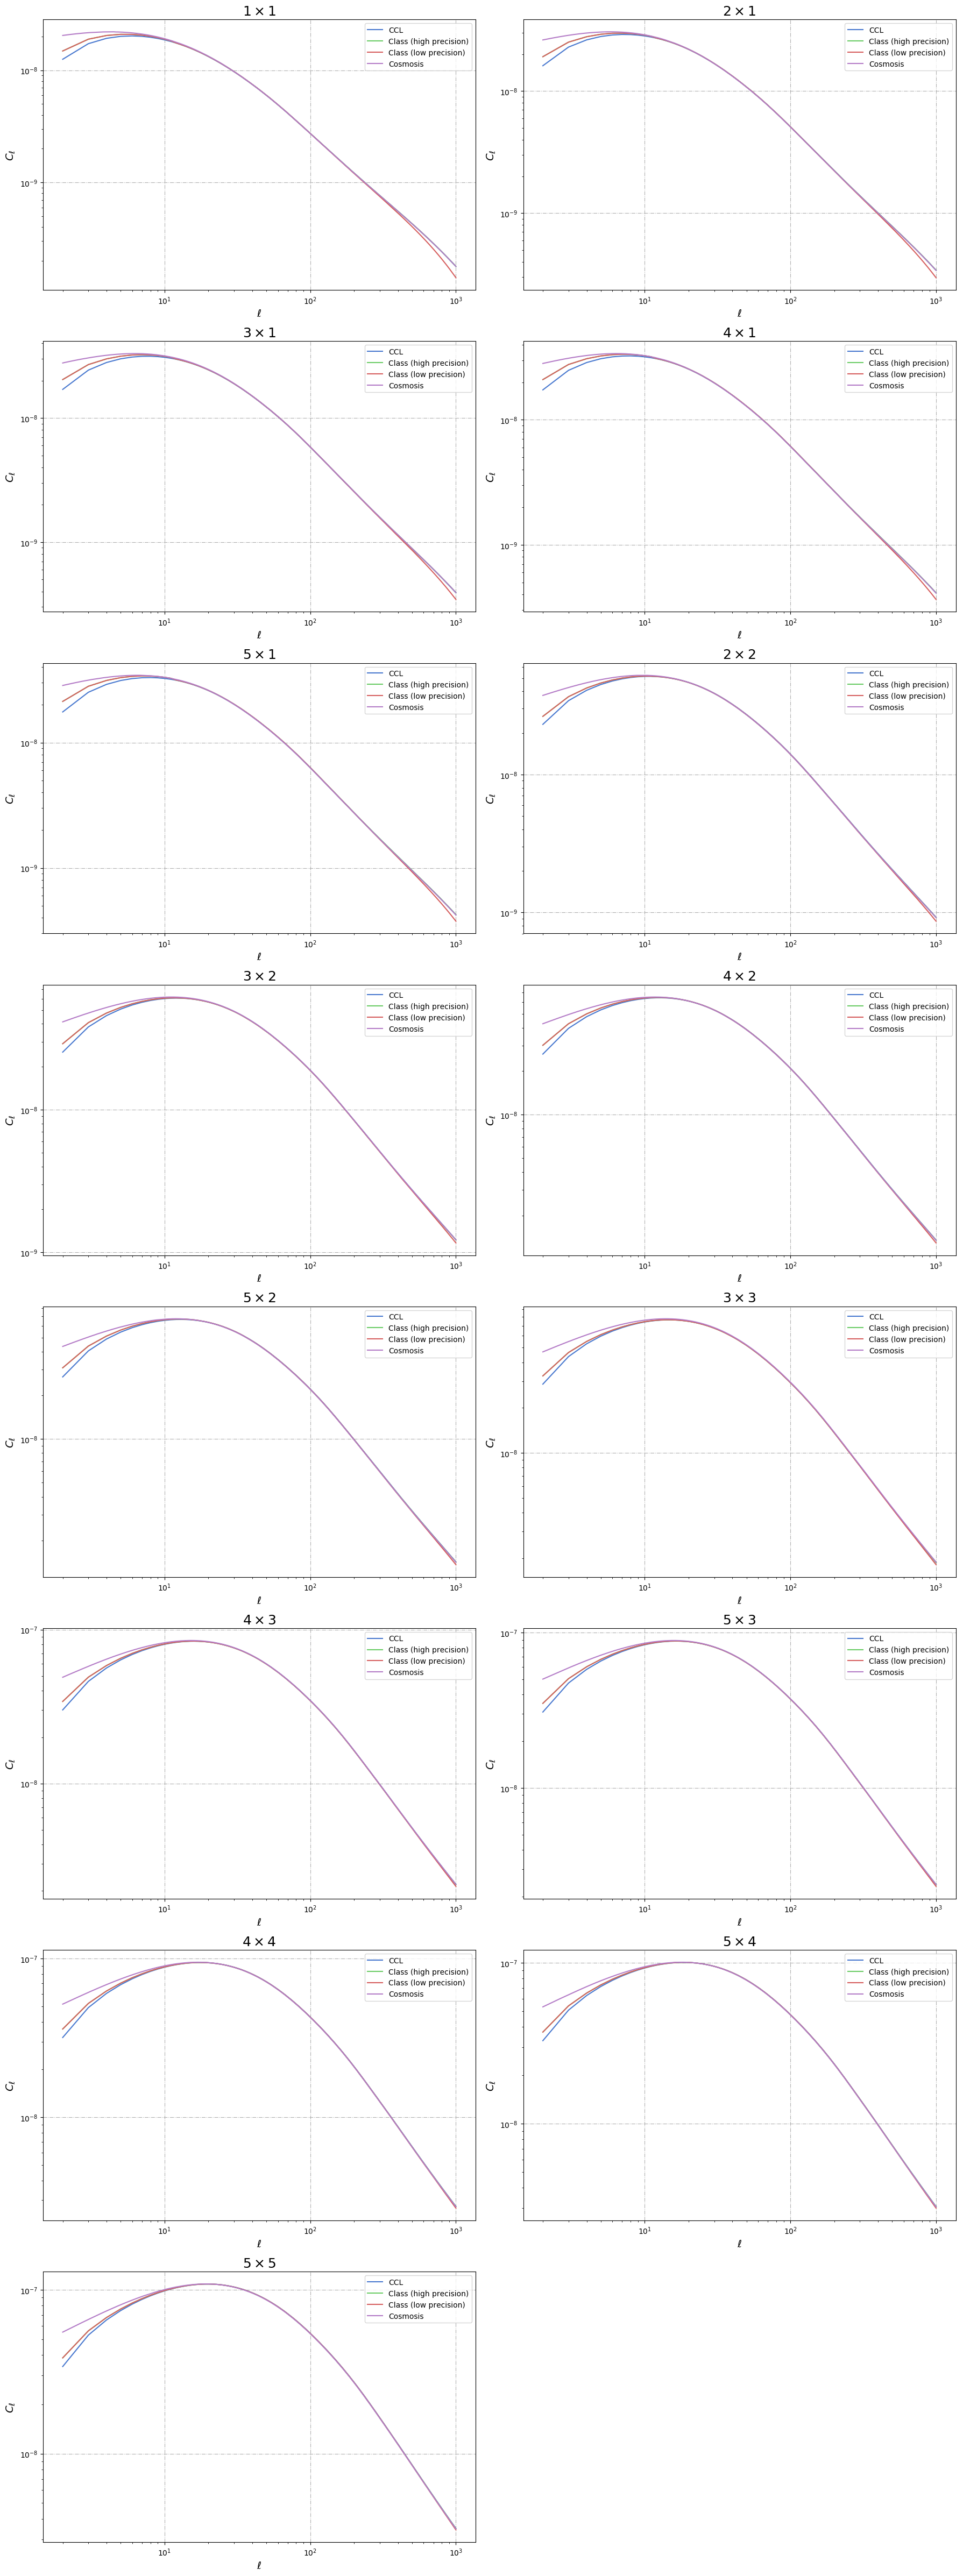

In [190]:
with plt.style.context('seaborn-muted'):
    fig, ax = plt.subplots(figsize = (18,48), nrows=8, ncols=2, dpi=100)
    ind = 0
    # ind2 = 1
    for row in ax:
        for col in row:
            if ind < 15:
                plt.grid(linestyle='-.')
                col.loglog(ells, ccl_cls[ind], '-' ,label="CCL")
                col.loglog(class_ell[2:], class_factor[2:] * class_density_cl['ll'][ind][2:], label="Class (high precision)")
                col.loglog(class_ell_cls_low[:, 0], class_ell_cls_low[:, ind+1], label="Class (low precision)")
                col.loglog(cosmosis_ells, cosmosis_cls[:, ind], label="Cosmosis")
                col.set_title(r'$%d \times %d$'%(class_ord[ind]), fontsize=18)
                col.set_xlabel(r'$\ell$', fontsize=14)
                col.set_ylabel(r'$C_\ell$', fontsize=14)
                col.legend()
                col.grid(linestyle='-.')
            ind +=1
    ax[-1, -1].remove()
    fig.tight_layout()
    # plt.savefig("plots/comp_Cl_cosmosis_ccl")
    plt.show()

Now we plot the ratios of CCL and COSMOSIS relative to CLASS, and below this we also show the same plot for $\ell \geq 50$

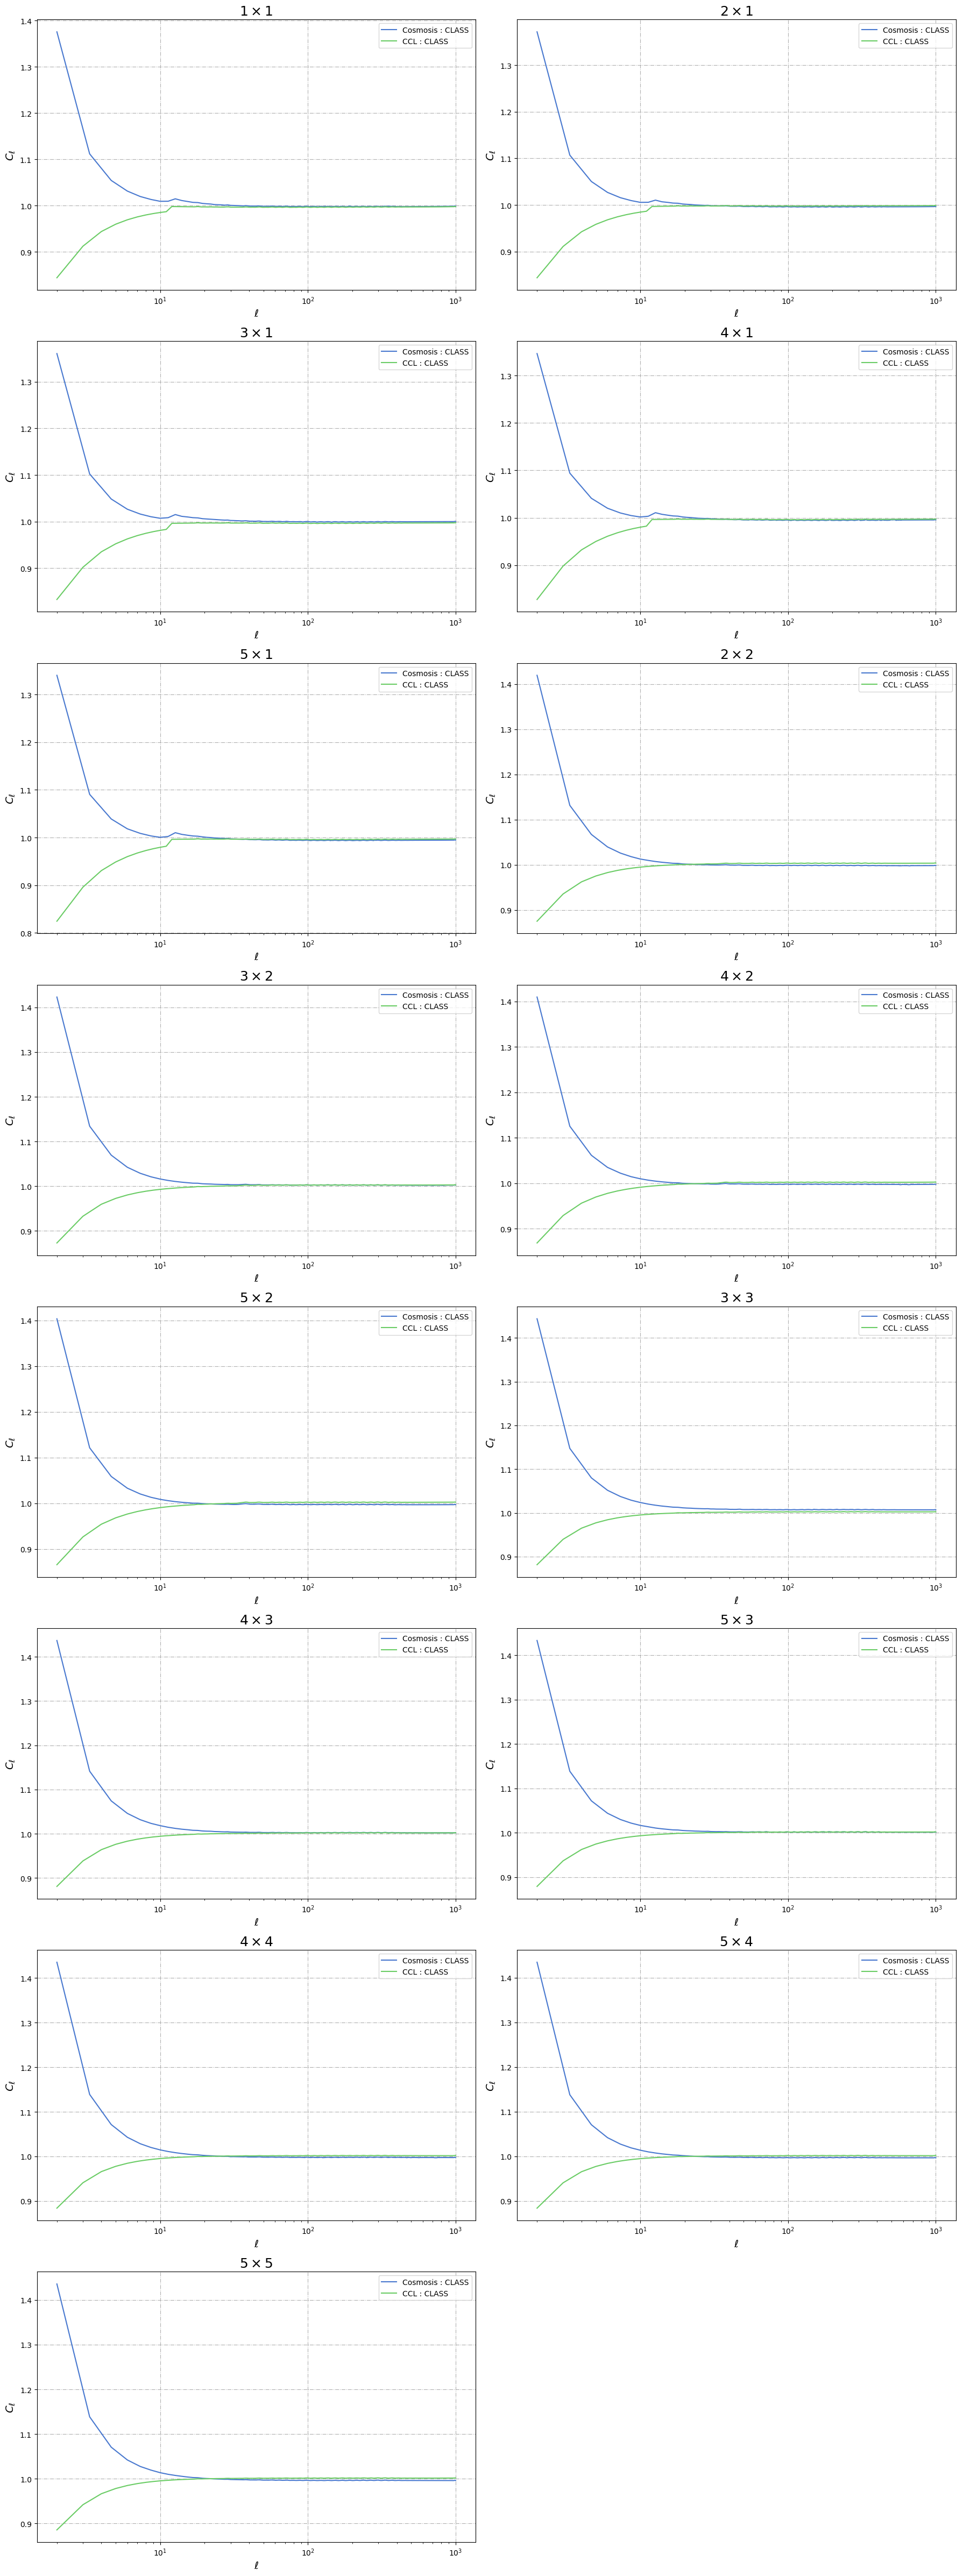

In [198]:
x = np.linspace(2, 1000, num=750)

with plt.style.context('seaborn-muted'):
    fig, ax = plt.subplots(figsize = (18,48), nrows=8, ncols=2, dpi=100)
    ind = 0
    for row in ax:
        for col in row:
            if ind < 15:
                plt.grid(linestyle='-.')
                f_cosmosis_cl = interp1d(cosmosis_ells, cosmosis_cls[:, ind], kind='cubic')
                f_class_cl    = interp1d(ells, class_factor[2:] * class_density_cl['ll'][ind][2:], kind='cubic')
    #             col.loglog(cosmosis_ells, cosmosis_cls[:, ind], label="Cosmosis")
    #             col.loglog(class_cl[:, 0], class_cl_dict[orderings[ind]][:], label="Bridges Class")
                col.semilogx(x, f_cosmosis_cl(x)/f_class_cl(x), label="Cosmosis : CLASS")
                col.semilogx(ells, ccl_cls[ind]/(class_factor[2:] * class_density_cl['ll'][ind][2:]), label="CCL : CLASS")
                col.set_title(r'$%d \times %d$'%(class_ord[ind]), fontsize=18)
                col.set_xlabel(r'$\ell$', fontsize=14)
                col.set_ylabel(r'$C_\ell$', fontsize=14)
                col.legend()
                col.grid(linestyle='-.')
            ind +=1
    ax[-1, -1].remove()
    fig.tight_layout()
    # plt.savefig("plots/comp_Cl_cosmosis_ccl")
    plt.show()

Let's focus on the ells after 50

In [200]:
ells[48]

50

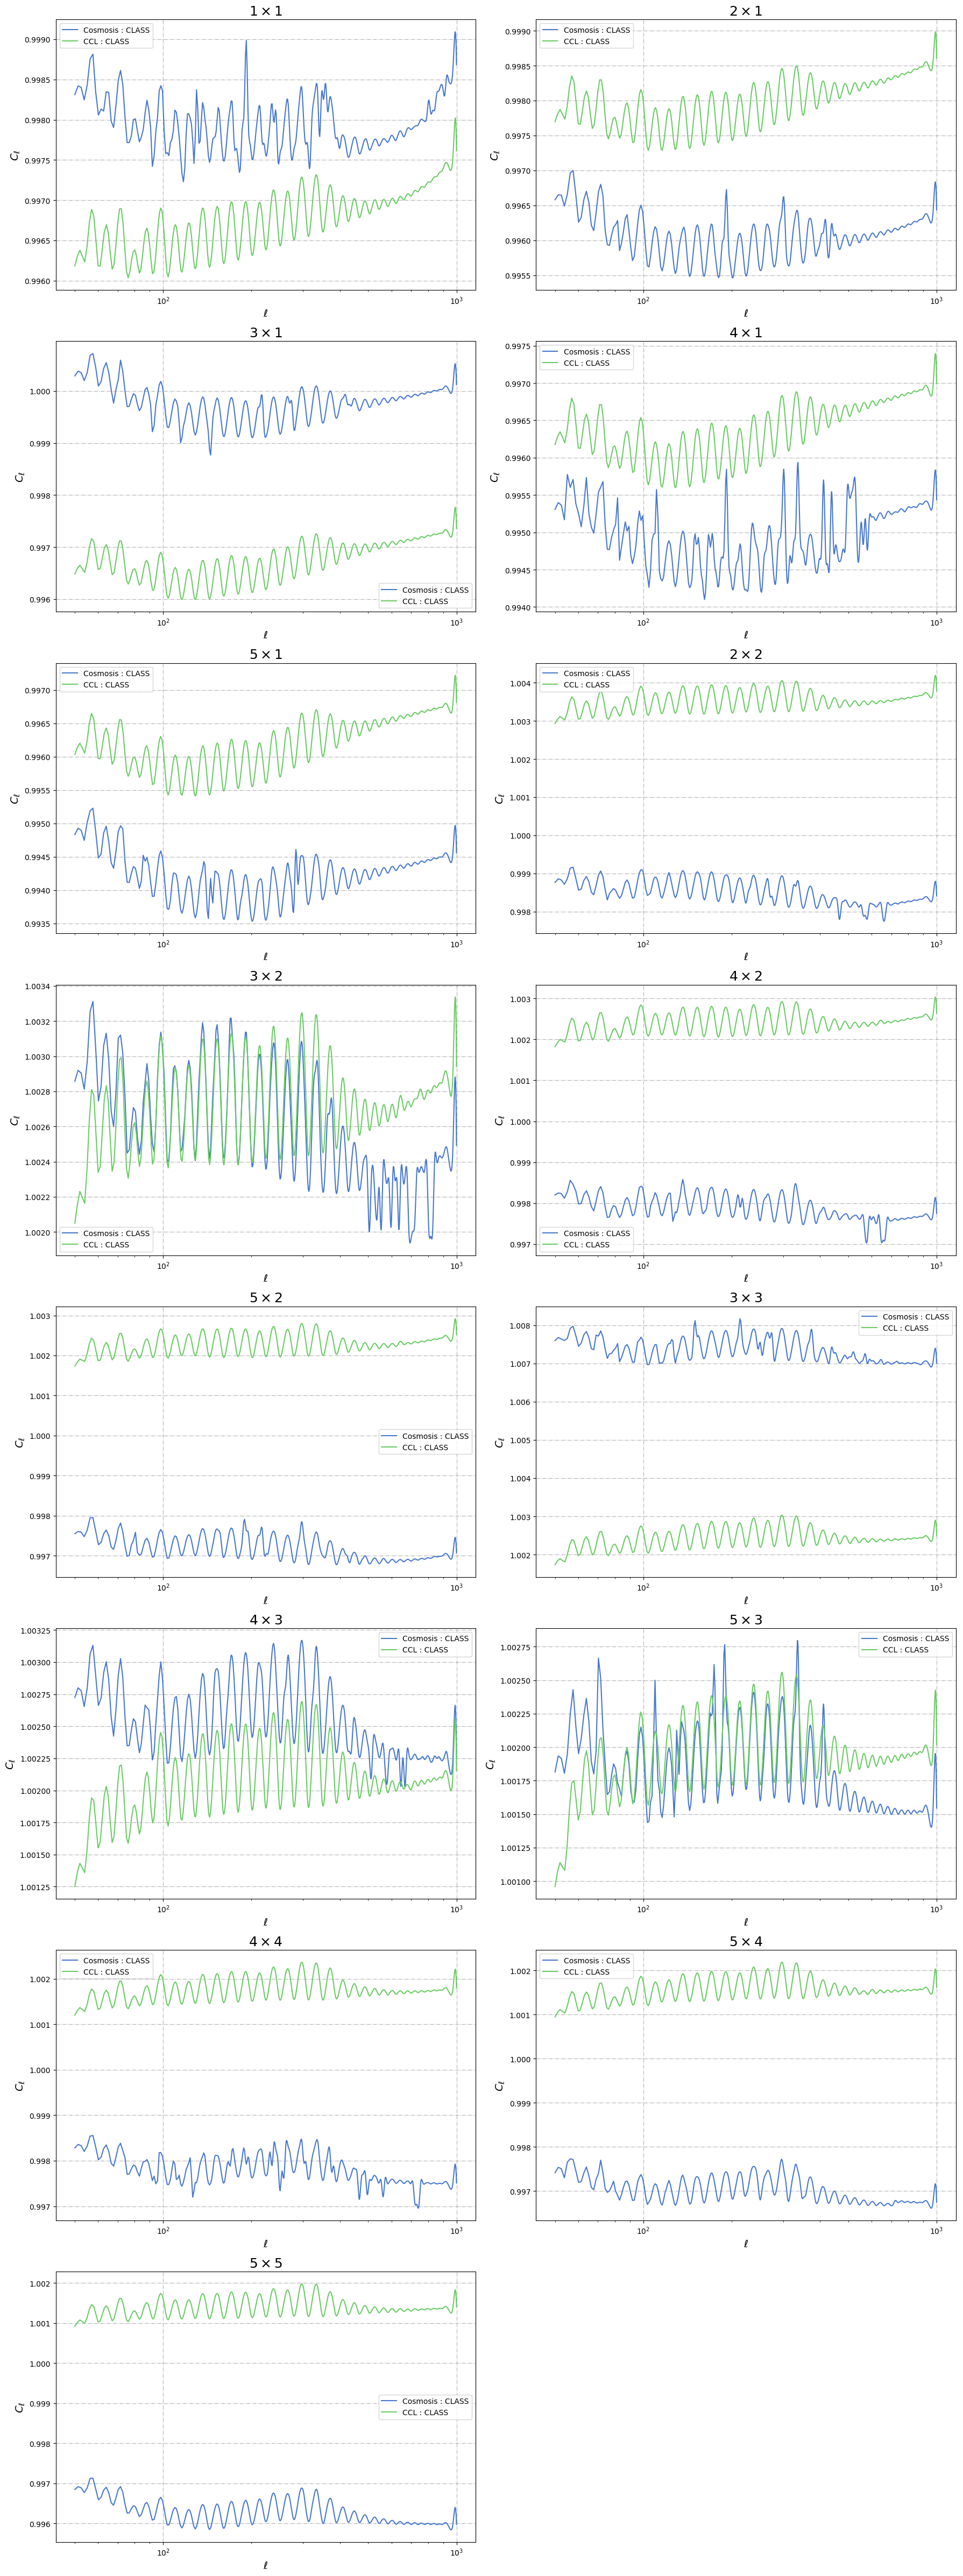

In [202]:
x = np.linspace(50, 1000, num=750, endpoint=True)

with plt.style.context('seaborn-muted'):
    fig, ax = plt.subplots(figsize = (18,48), nrows=8, ncols=2, dpi=100)
    ind = 0
    for row in ax:
        for col in row:
            if ind < 15:
                plt.grid(linestyle='-.')
                f_cosmosis_cl = interp1d(cosmosis_ells, cosmosis_cls[:, ind], kind='cubic')
                f_class_cl    = interp1d(ells, class_factor[2:] * class_density_cl['ll'][ind][2:], kind='cubic')
    #             col.loglog(cosmosis_ells, cosmosis_cls[:, ind], label="Cosmosis")
    #             col.loglog(class_cl[:, 0], class_cl_dict[orderings[ind]][:], label="Bridges Class")
                col.semilogx(x, f_cosmosis_cl(x)/f_class_cl(x), label="Cosmosis : CLASS")
                col.semilogx(ells[48:], ccl_cls[ind][48:]/(class_factor[2+48:] * class_density_cl['ll'][ind][2+48:]), label="CCL : CLASS")
                col.set_title(r'$%d \times %d$'%(class_ord[ind]), fontsize=18)
                col.set_xlabel(r'$\ell$', fontsize=14)
                col.set_ylabel(r'$C_\ell$', fontsize=14)
                col.legend()
                col.grid(linestyle='-.')
            ind +=1
    ax[-1, -1].remove()
    fig.tight_layout()
    # plt.savefig("plots/comp_Cl_cosmosis_ccl_zoom")
    plt.show()